In [97]:

#LIBRARIES
import pandas as pd
import numpy as np
import quandl
from dotenv import load_dotenv
import os
import datetime

#ML LIBRARIES
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#PLOTING LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

#DEEP LEARNING
import tensorflow as tf

#YAHOOFINANCIALS
from yahoofinancials import YahooFinancials

In [95]:
# GETS THE API KEY FROM .ENV FILE
def get_key(d_key):
    load_dotenv('.env')
    key = os.environ.get(d_key)
    return key

# GETS DATA FROM QUANDL / DEFAULT IS BOING DATA 
def quandl_get(code="EOD/BA", start_date="1970-01-01", end_date="2019-05-27"):
    return quandl.get(code, start_date=start_date, end_date=end_date)

# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng(df, n=10):
    
    df['Volatility'] = (df['Adj_High'] - df['Adj_Low']) / df['Adj_Low']
    df['Change'] = (df['Adj_Close'] - df['Adj_Open']) / df['Adj_Open']
    df = df[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']]
    
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df
    
    
#PLOTS CORRELATION HEATMAP AND SAVES
def plot_corr(df,size=10, title = 'Correlation'):
    style.use('ggplot')
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(corr, annot=True, cmap="Blues").set_title(title)
    fig.savefig('images/corr_heatmap.png')

#TRAIN LINEAR REGRESSION 
def LR_train(data):
    df = data.dropna()
    X = df.drop('future_price10d', axis=1)
    y = df['future_price10d']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    reg = LinearRegression(n_jobs=-1)
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    print('----- * SCORE * -----\n\n{}%\n\n----- * SCORE * -----'.format(round(score*100,2)))
    return score, reg

#PREDICT FUTURE VALUES
def LR_predict(df, reg ,n=10):
    X = df.drop('future_price10d', axis=1)
    X_predict = X[-n:]
    predictions = reg.predict(X_predict)
    len(df)
    prediction_column = [np.nan for _ in range(len(df)-10)]
    prediction_column.extend(predictions)
    df['Predictions'] = prediction_column
    return predictions, df


#PLOT STOCK PRICE VS TIME
def plot_stock(df, col, size=10, title='Stock'):
    style.use('ggplot')
    fig = df[[col]].plot(cmap="GnBu_r", figsize=(size,size)).set_title(title).get_figure()
    fig.savefig('images/stock.png')
    

#PLOT PREDICTIONS
def plot_predictions(df, col, size=10, title='Stock'):
    style.use('ggplot')
    fig = df[col][-30:].plot( figsize=(size,size)).set_title(title).get_figure()
    fig.savefig('images/predictions.png')
    
#!!!! train lstm model !!!!

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


----- * SCORE * -----

98.04%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


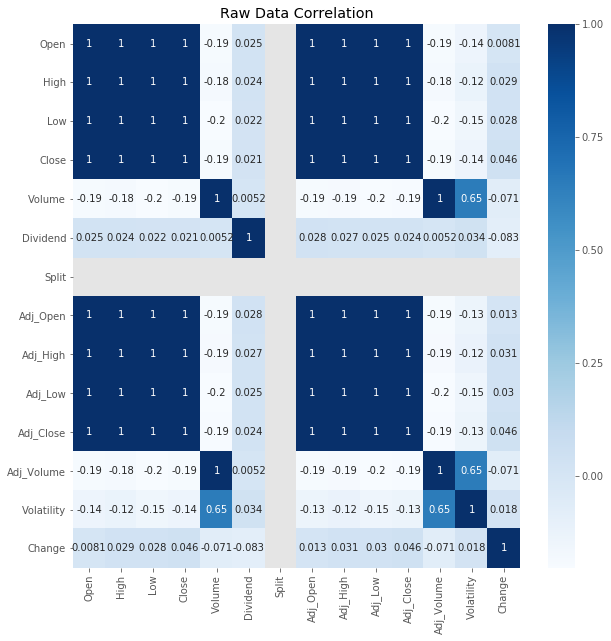

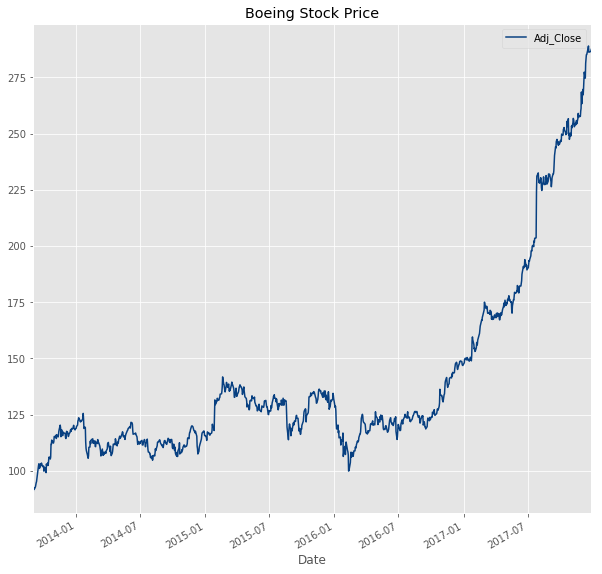

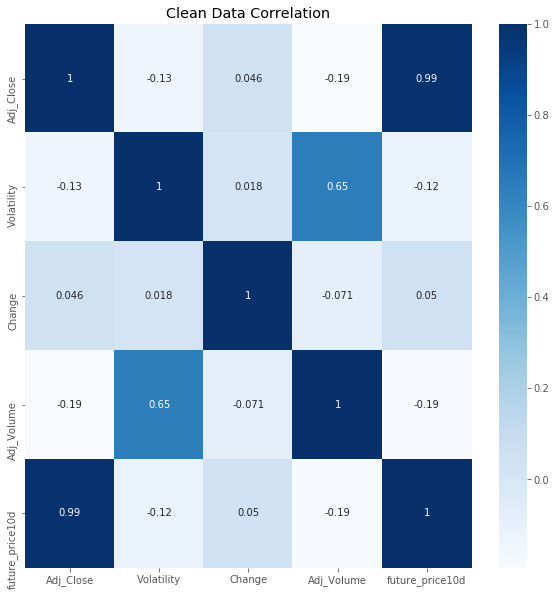

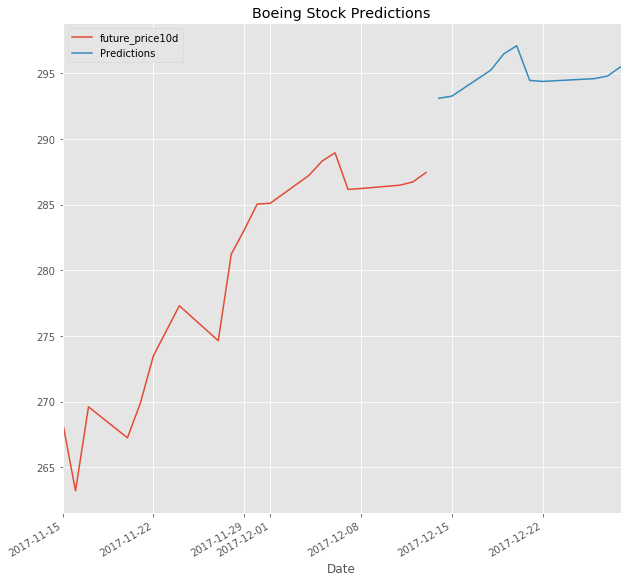

In [96]:
if __name__ == "__main__":
    days_predict = 10
    quandl_key = get_key('quandl_key')
    quandl.ApiConfig.api_key = quandl_key
    #boeing = quandl_get()
    plot_corr(boeing, 10, 'Raw Data Correlation')
    boeing_clean = feature_eng(boeing, days_predict)
    plot_stock(boeing_clean, 'Adj_Close',10,'Boeing Stock Price')
    plot_corr(boeing_clean, 10,'Clean Data Correlation')
    score, reg = LR_train(boeing_clean)
    predictions, boeing_predicted = LR_predict(boeing_clean, reg, days_predict)
    plot_predictions(boeing_predicted,['future_price10d', 'Predictions'] , 10, 'Boeing Stock Predictions')

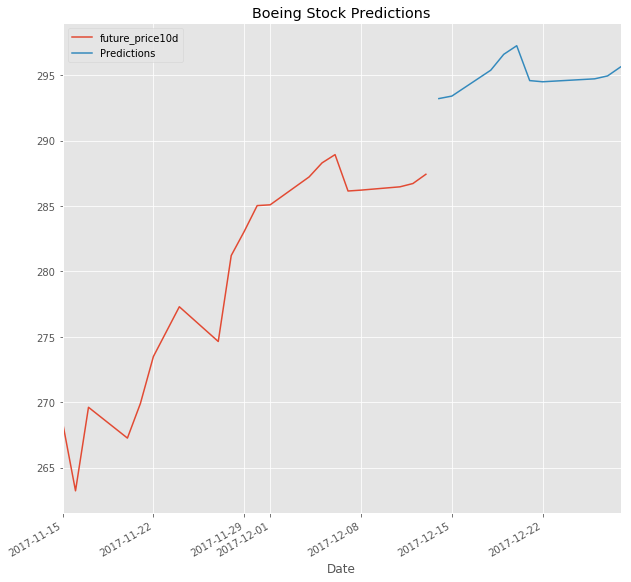

In [108]:

ticker = 'AAPL'
yahoo_financials = YahooFinancials(ticker)
apple = yahoo_financials.get_historical_price_data('2017-05-30', '2019-05-30', 'daily')

In [120]:
apple_df = pd.DataFrame(apple['AAPL']['prices'])

In [122]:
apple_df.tail()

,adjclose,close,date,formatted_date,high,low,open,volume
498,182.779999,182.779999,1558531800,2019-05-22,185.710007,182.550003,184.660004,29748600
499,179.660004,179.660004,1558618200,2019-05-23,180.539993,177.809998,179.800003,36529700
500,178.970001,178.970001,1558704600,2019-05-24,182.139999,178.619995,180.199997,23714700
501,178.229996,178.229996,1559050200,2019-05-28,180.589996,177.910004,178.919998,27948200
502,177.380005,177.380005,1559136600,2019-05-29,179.350006,176.000000,176.419998,28452000


In [123]:
apple_clean = feature_eng(apple_df, days_predict)

KeyError: 'Adj_High'